## Семинар 2 "Распознавание рукописных цифр"

ФИО: Устинов Иван Вадимович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [11]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Processing...
Done!


In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

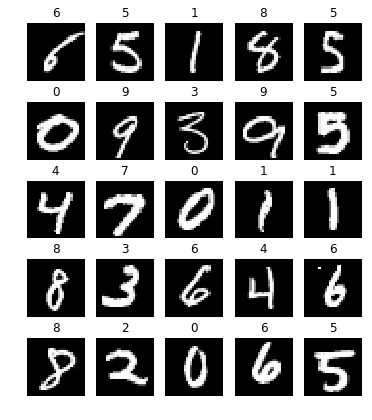

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [74]:
def train(train_loader, test_loader, network, epochs,
          learning_rate, plot=True, verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 14... (Train/Test) NLL: 0.109/0.130	Accuracy: 0.970/0.963

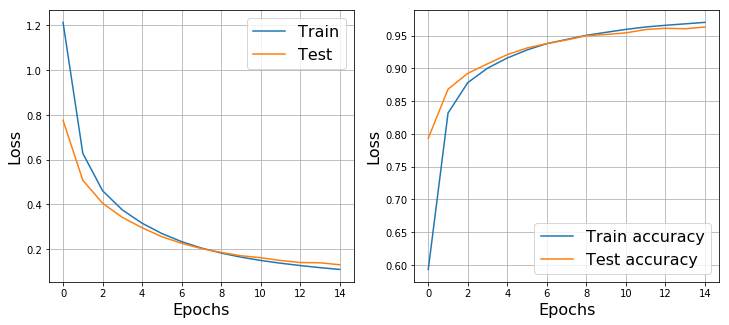

In [13]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 15, 0.03)

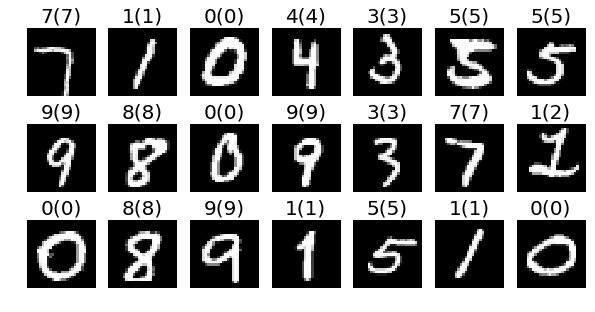

In [52]:
plt.figure(figsize=(10, 5))
for i in range(21):
    plt.subplot(3, 7, i+1)
    predict = network.forward(X[i])
    predict = np.exp(predict)
    predict /= predict.sum(0, keepdims=True)
#     plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(y[i], np.argmax(predict)), fontsize=20)
    plt.axis('off')

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [14]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.X = X
        return np.maximum(X, 0)
    
    def backward(self, dLdy):
        # return dLdX
        dydX = (self.X > 0).astype(float)
        return dLdy * dydX
    
    def step(self, learning_rate):
        pass

In [55]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [53]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 10, 0.04, plot=False, verbose=False)

In [64]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 10, 0.04, plot=False, verbose=False)

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [59]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

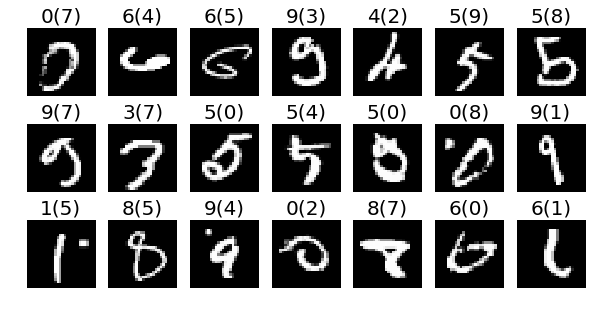

In [60]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### HW1 (1 балл): Реализовать Tanh

In [61]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.X = X
        return (np.exp(2*X) - 1) / (np.exp(2*X) + 1)
    
    def backward(self, dLdy):
        X = self.X
        dydX = 4 / ((np.exp(X) + np.exp(-X)) ** 2)
        return dLdy * dydX
    
    def step(self, learning_rate):
        pass

In [65]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 10, 0.04, plot=False, verbose=False)

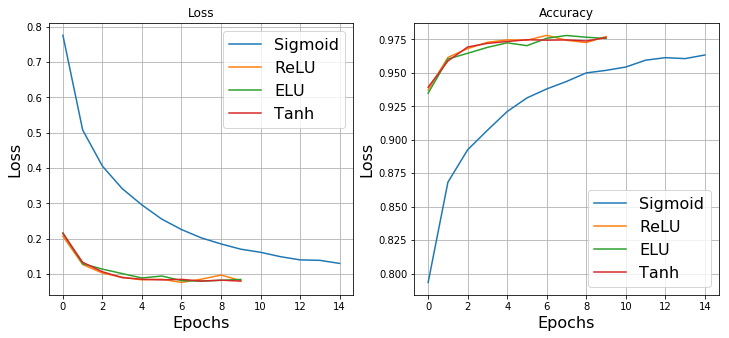

In [66]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [93]:
def LearnWithAugmentation(transform):
    train_dataset = MNIST('.', train=True, download=True, transform=transform)
    test_dataset = MNIST('.', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    
    network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
    
    tr_, ts_, tr_ac_, ts_ac_ = train(train_loader, test_loader, network,
                                     10, 0.04, plot=False, verbose=True)

    return ts_ac_

#### Поворот (-15, 15) градусов

In [83]:
import pandas as pd
scores_aug = pd.DataFrame(columns=['rotate', 'noise', 'affine', 'all'], index=range(10))

In [86]:
transform = transforms.Compose([
                   transforms.RandomRotation(degrees=(-15,15)),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
                ])
scores_aug['rotate'] = LearnWithAugmentation(transform)

Epoch 9... (Train/Test) NLL: 0.064/0.077	Accuracy: 0.980/0.975

#### смещение

In [87]:
transform = transforms.Compose([
                   transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
                ])
scores_aug['affine'] = LearnWithAugmentation(transform)

Epoch 9... (Train/Test) NLL: 0.069/0.071	Accuracy: 0.979/0.979

In [88]:
scores_aug['without_aug'] = ts_ac_r

In [90]:
scores_aug.to_csv('scores_aug_table.csv')

#### шум

In [91]:
from PIL import Image

class RandomNoise:
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, image):
        numpy_image = np.asarray(image, dtype=np.float64)
        
        numpy_image = numpy_image + np.random.normal(scale=self.scale, size=image.size)
        
        return Image.fromarray(numpy_image)

In [95]:
transform = transforms.Compose([
                       RandomNoise(1),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

scores_aug['noise'] = LearnWithAugmentation(transform)

Epoch 9... (Train/Test) NLL: 2.301/2.302	Accuracy: 0.112/0.113

#### С шумом совсем плохо получилось

#### Поворот + сдвиг (без шума - т.к. видимо он сильно портит всё)

In [97]:
transform = transforms.Compose([
                       transforms.RandomAffine(degrees=(-15,15),
                                               translate=(0.05,0.05)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

scores_aug['all'] = LearnWithAugmentation(transform)

Epoch 9... (Train/Test) NLL: 0.096/0.093	Accuracy: 0.969/0.971

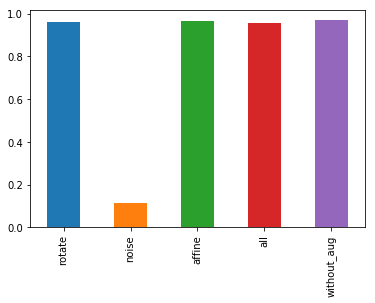

In [99]:
scores_aug.mean(0).plot(kind='bar')

In [103]:
scores_aug.mean(0)

rotate         0.962650
noise          0.113508
affine         0.964337
all            0.956829
without_aug    0.969109
dtype: float64

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Вцелом RelU, ELU, Tanh - одинаковы для использования в этой задаче и гораздо лучше себя показывают, в отличие от сигмоиды. Небольшое преимущество есть у ReLU, т.к. его легче и быстрее считать.

Кастально аугментации: шум всё очень портит и не подходит в данном случае; неплохо показали себя отдельно сдвиг и поворот, но преимущества не дали.